# Stock Prediction by analysing sentiments of tweets
In this module we'll be trying to make an classifier which would be able to tell whether a company's stock price might increase or decrease based on average setiments of tweets relared to that company in a predefined window

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importing the processed data for applications
Here the first column represents the time interval which we have taken in this case a window of 5 min. The second column has the average sentiment of tweet on a scale of 1-5 in previous time window and the third column is the change in the stock price.

In [115]:
data = pd.read_csv('stock_tweet.csv') 
data

,DateTime,SENTIMENT,change
0,2022-01-12 09:30:00,1.000000,0.889999
1,2022-01-12 09:35:00,3.000000,-0.009995
2,2022-01-12 09:40:00,1.000000,-0.029892
3,2022-01-12 09:45:00,1.000000,-2.074707
4,2022-01-12 09:50:00,4.000000,-0.889999
...,...,...,...
1462,2022-12-28 14:50:00,2.500000,0.123596
1463,2022-12-28 14:55:00,1.888889,-0.709099
1464,2022-12-28 15:00:00,2.555556,-0.840004
1465,2022-12-28 15:05:00,2.333333,-0.084000


### Normalizing the columns
This would allow us to better visualize the sentiments and tweets corelation

In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# copy the data
df_max_scaled = data.copy()

# apply normalization techniques
column = 'SENTIMENT'
df_max_scaled[column] = MinMaxScaler().fit_transform(np.array(df_max_scaled[column]).reshape(-1,1))

column = 'change'
df_max_scaled[column] = MinMaxScaler().fit_transform(np.array(df_max_scaled[column]).reshape(-1,1))

# view normalized data
display(df_max_scaled)


,DateTime,SENTIMENT,change
0,2022-01-12 09:30:00,0.000000,0.575419
1,2022-01-12 09:35:00,0.500000,0.449721
2,2022-01-12 09:40:00,0.000000,0.446942
3,2022-01-12 09:45:00,0.000000,0.161353
4,2022-01-12 09:50:00,0.750000,0.326815
...,...,...,...
1462,2022-12-28 14:50:00,0.375000,0.468379
1463,2022-12-28 14:55:00,0.222222,0.352081
1464,2022-12-28 15:00:00,0.388889,0.333798
1465,2022-12-28 15:05:00,0.333333,0.439385


### Plotting sentiments and chnage in stock price in various time intervals
Here we are taking a section of whole data for better visualisation

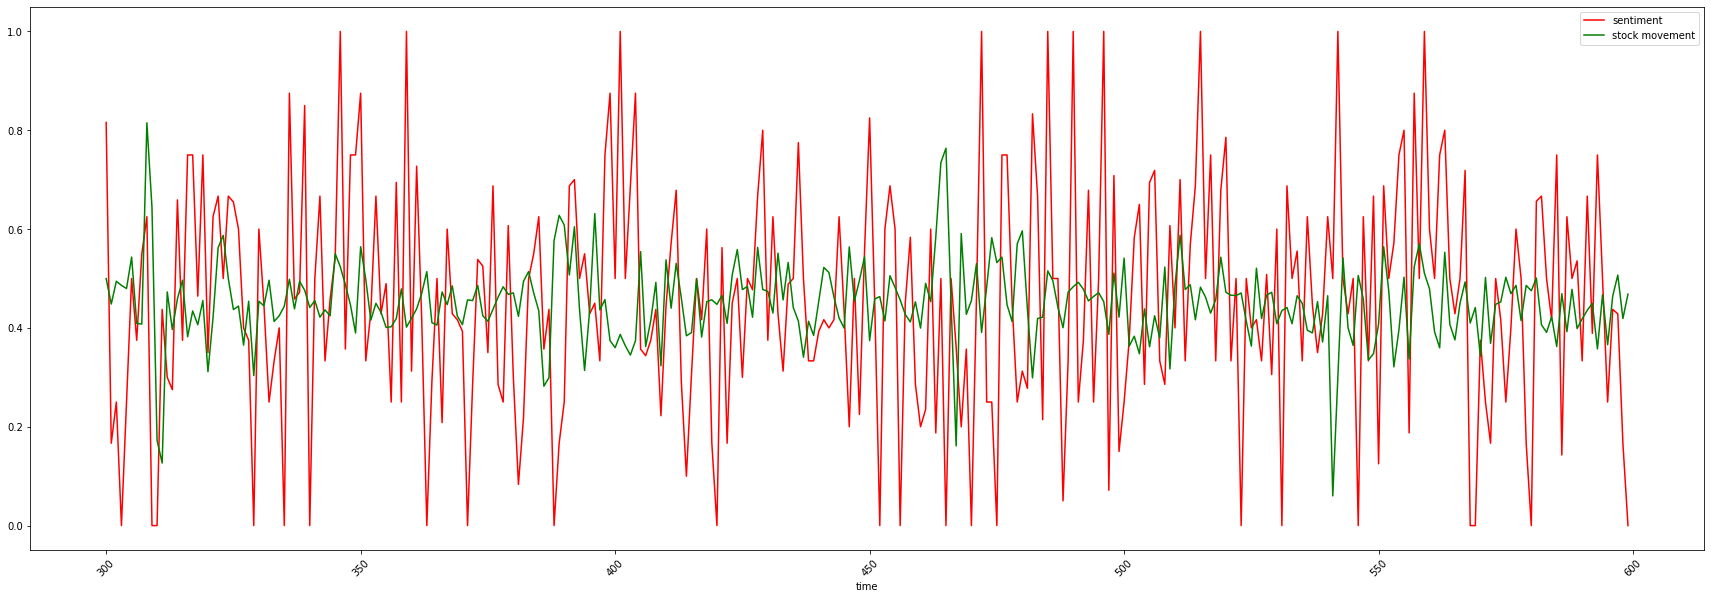

In [37]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(30, 10))
plt.plot(df_max_scaled['SENTIMENT'][300:600], color = 'r' , label = 'sentiment')
plt.plot(df_max_scaled['change'][300:600] , color = 'g' , label = 'stock movement')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

### Splitting data into training and test set

In [116]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1, shuffle = False)

### Normalizing the sentiment columns for optimization

In [117]:
# copy the data
df_max_scaled = train.copy()

# apply normalization techniques
column = 'SENTIMENT'
df_max_scaled[column] = MinMaxScaler().fit_transform(np.array(df_max_scaled[column]).reshape(-1,1))

# view normalized data
display(df_max_scaled)

train = df_max_scaled

,DateTime,SENTIMENT,change
0,2022-01-12 09:30:00,0.000000,0.889999
1,2022-01-12 09:35:00,0.500000,-0.009995
2,2022-01-12 09:40:00,0.000000,-0.029892
3,2022-01-12 09:45:00,0.000000,-2.074707
4,2022-01-12 09:50:00,0.750000,-0.889999
...,...,...,...
1315,2022-12-23 15:35:00,0.361111,-0.609200
1316,2022-12-23 15:40:00,0.467391,0.028999
1317,2022-12-23 15:45:00,0.480769,-0.465004
1318,2022-12-23 15:50:00,0.442308,0.369995


In [118]:
# copy the data
df_max_scaled = test.copy()

# apply normalization techniques
column = 'SENTIMENT'
df_max_scaled[column] = MinMaxScaler().fit_transform(np.array(df_max_scaled[column]).reshape(-1,1))

# view normalized data
display(df_max_scaled)

test = df_max_scaled

,DateTime,SENTIMENT,change
1320,2022-12-27 09:30:00,0.000000,1.724998
1321,2022-12-27 09:35:00,0.000000,-2.230003
1322,2022-12-27 09:40:00,0.000000,-0.739998
1323,2022-12-27 09:45:00,0.666667,-0.464897
1324,2022-12-27 09:50:00,0.800000,0.130005
...,...,...,...
1462,2022-12-28 14:50:00,0.375000,0.123596
1463,2022-12-28 14:55:00,0.222222,-0.709099
1464,2022-12-28 15:00:00,0.388889,-0.840004
1465,2022-12-28 15:05:00,0.333333,-0.084000


### Getting data ready for classification problem

In [119]:
x_train = train['SENTIMENT'].to_list()
y_train = train['change'].to_list()
x_test = test['SENTIMENT'].to_list()
y_test = test['change'].to_list()

Here we will be just trying to predict whether a stock might go up or down based on the sentiment score

In [120]:
y_train = [1 if x > 0 else 0 for x in y_train]
y_test = [1 if x > 0 else 0 for x in y_test]

In [121]:
y_train = [np.array([0,1]) if x > 0 else np.array([1,0]) for x in y_train]
y_test = [np.array([0,1]) if x > 0 else np.array([1,0]) for x in y_test]

In [122]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1320, 1)
(1320, 2)
(147, 1)
(147, 2)


In [123]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

### LSTM Neural network

In [124]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_dim, num_layers, output_size):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out) 
    return out

### Setting up the hyper parameters

In [125]:
input_size = 1
hidden_dim = 32
num_layers = 2
output_size = 2
num_epochs = 50

In [126]:
model = LSTM(input_size = input_size, hidden_dim = hidden_dim, num_layers = num_layers, output_size = output_size)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

### Training our neural network

In [127]:
for epochs in range(num_epochs):
  y_pred = model(x_train)
  loss = criterion(y_pred, y_train)
  if epochs%10 == 0:
    print("Epoch ", epochs, "BCELoss: ", loss.item())
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

Epoch  0 BCELoss:  0.3982599377632141
Epoch  10 BCELoss:  0.2537279725074768
Epoch  20 BCELoss:  0.2505173981189728
Epoch  30 BCELoss:  0.2504124641418457
Epoch  40 BCELoss:  0.2501075565814972


### Evaluating the performance of neural network

In [128]:
y_out = model(x_test)

In [129]:
y_out = y_out.detach().numpy()

In [130]:
for idx in range(len(y_out)):
  i = np.argmax(y_out[idx])
  y_out[idx] = np.zeros(2)
  y_out[idx][i] = 1

In [131]:
y_test = y_test.detach().numpy()

In [132]:
correct = 0
for i in range(len(y_test)):
  if y_test[i][0] == y_out[i][0] and y_test[i][1] == y_out[i][1]:
    correct +=1
print("Accuracy is ", correct / len(y_test))

Accuracy is  0.5374149659863946


# Result
We are getting an accuracy of 53% which is just better than one that we might had got from random guess that is 50%. Hence we can say that we can't merely predict the change in stock price solely on basis on sentiments of tweets in such a small window
